Import libraries of Python

In [6]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

Load the Data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/chatgpt_reviews.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [10]:
df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


Data Cleaning and Preprocessing

In [11]:
print(df.columns)
df.columns = df.columns.str.lower().str.replace(' ','_')
print(df.columns)

Index(['Review Id', 'Review', 'Ratings', 'Review Date'], dtype='object')
Index(['review_id', 'review', 'ratings', 'review_date'], dtype='object')


In [13]:
df.head()

,review_id,review,ratings,review_date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


In [19]:
df['review'] = df['review'].fillna('')
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

In [18]:
df.isnull().sum()

,0
review_id,0
review,0
ratings,0
review_date,0


# **Sentiment Analysis**

Classification of positive/negative and neutral reviews


Analysis and Insights

In [39]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['polarity'] = df['review'].apply(get_sentiment)

def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['polarity'].apply(classify_sentiment)

df.head()
#display(df['sentiment'].value_counts())

,review_id,review,ratings,review_date,polarity,sentiment,review_day
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,0.7000,Positive,2024-08-23
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,0.7000,Positive,2024-08-23
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,0.6000,Positive,2024-08-23
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,0.6000,Positive,2024-08-23
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,0.4125,Positive,2024-08-23


Identifying in each bucket how many common words are there

In [40]:
display(df['sentiment'].value_counts())

,count
sentiment,
Positive,150122
Neutral,38450
Negative,8155


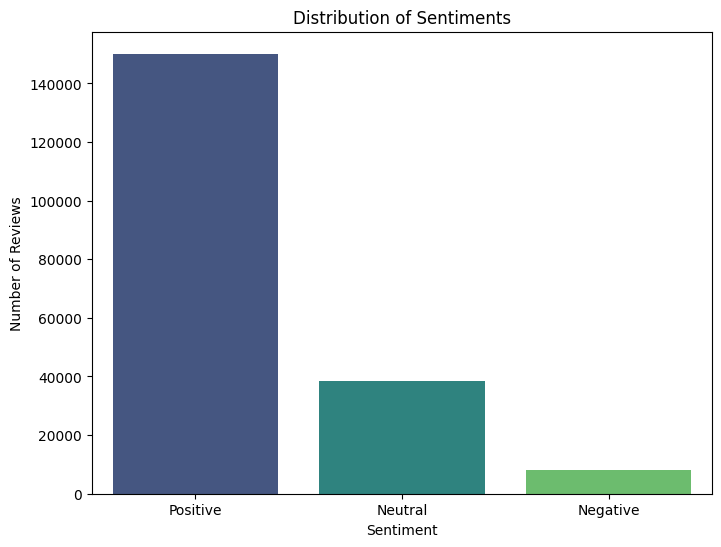

In [24]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=sentiment_counts.index, legend=False)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

Trend over time

<Figure size 1200x600 with 0 Axes>

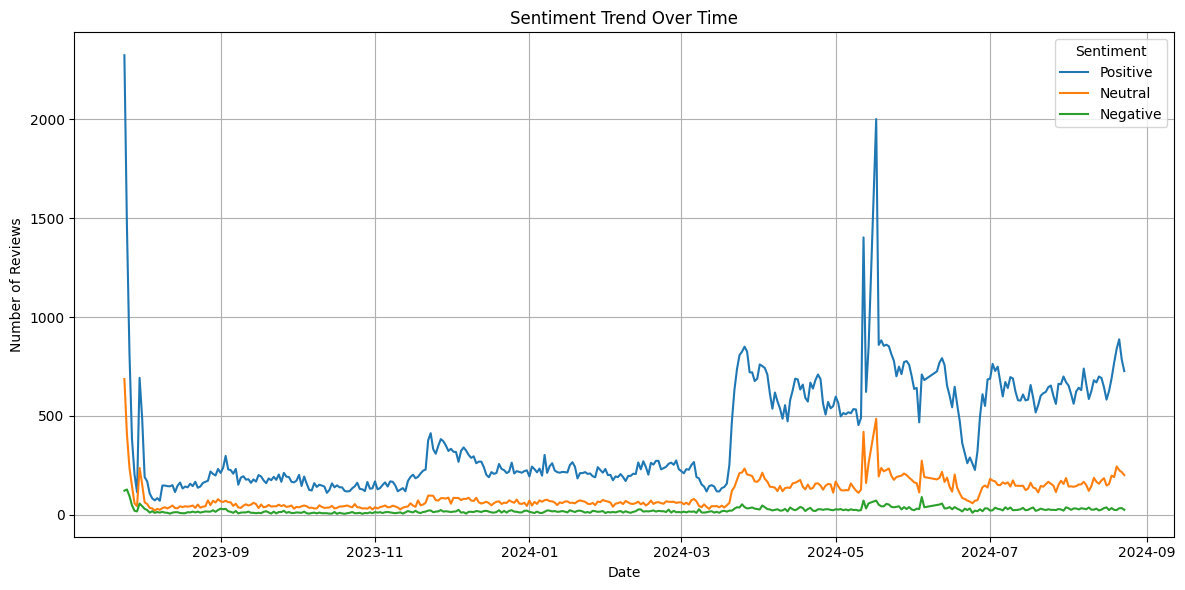

In [25]:
df['review_day'] = df['review_date'].dt.date
daily_sentiment = df.groupby(['review_day', 'sentiment']).size().unstack(fill_value=0)
daily_sentiment = daily_sentiment.reindex(columns=['Positive', 'Neutral', 'Negative'], fill_value=0)

plt.figure(figsize=(12, 6))
daily_sentiment.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Common words in positive and negative reviews

In [26]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 1]
    return words

positive_reviews = df[df['sentiment'] == 'Positive']['review'].apply(preprocess_text)
negative_reviews = df[df['sentiment'] == 'Negative']['review'].apply(preprocess_text)

all_positive_words = [word for sublist in positive_reviews for word in sublist]
all_negative_words = [word for sublist in negative_reviews for word in sublist]

common_positive_words = Counter(all_positive_words).most_common(20)
common_negative_words = Counter(all_negative_words).most_common(20)

print('Common words in Positive Reviews:')
for word, count in common_positive_words:
    print(f'- {word}: {count}')

print('\nCommon words in Negative Reviews:')
for word, count in common_negative_words:
    print(f'- {word}: {count}')

Common words in Positive Reviews:
- app: 44213
- good: 39063
- best: 18317
- nice: 13719
- great: 11876
- ai: 10248
- helpful: 9695
- amazing: 8624
- love: 8557
- chatgpt: 8282
- useful: 7507
- really: 7091
- like: 6816
- use: 6177
- excellent: 6121
- awesome: 5035
- chat: 4768
- gpt: 4006
- much: 3981
- ever: 3830

Common words in Negative Reviews:
- app: 2398
- wrong: 856
- bad: 853
- chatgpt: 772
- cant: 696
- ai: 675
- like: 649
- use: 641
- time: 605
- even: 585
- answer: 563
- chat: 549
- dont: 513
- im: 448
- information: 435
- doesnt: 433
- please: 431
- gpt: 426
- give: 405
- answers: 403


Visualization of count of common words in Positive/Negative Reviews

In [27]:
num_common_positive = len(common_positive_words)
num_common_negative = len(common_negative_words)

print(f"Number of common words in Positive Reviews: {num_common_positive}")
print(f"Number of common words in Negative Reviews: {num_common_negative}")

Number of common words in Positive Reviews: 20
Number of common words in Negative Reviews: 20


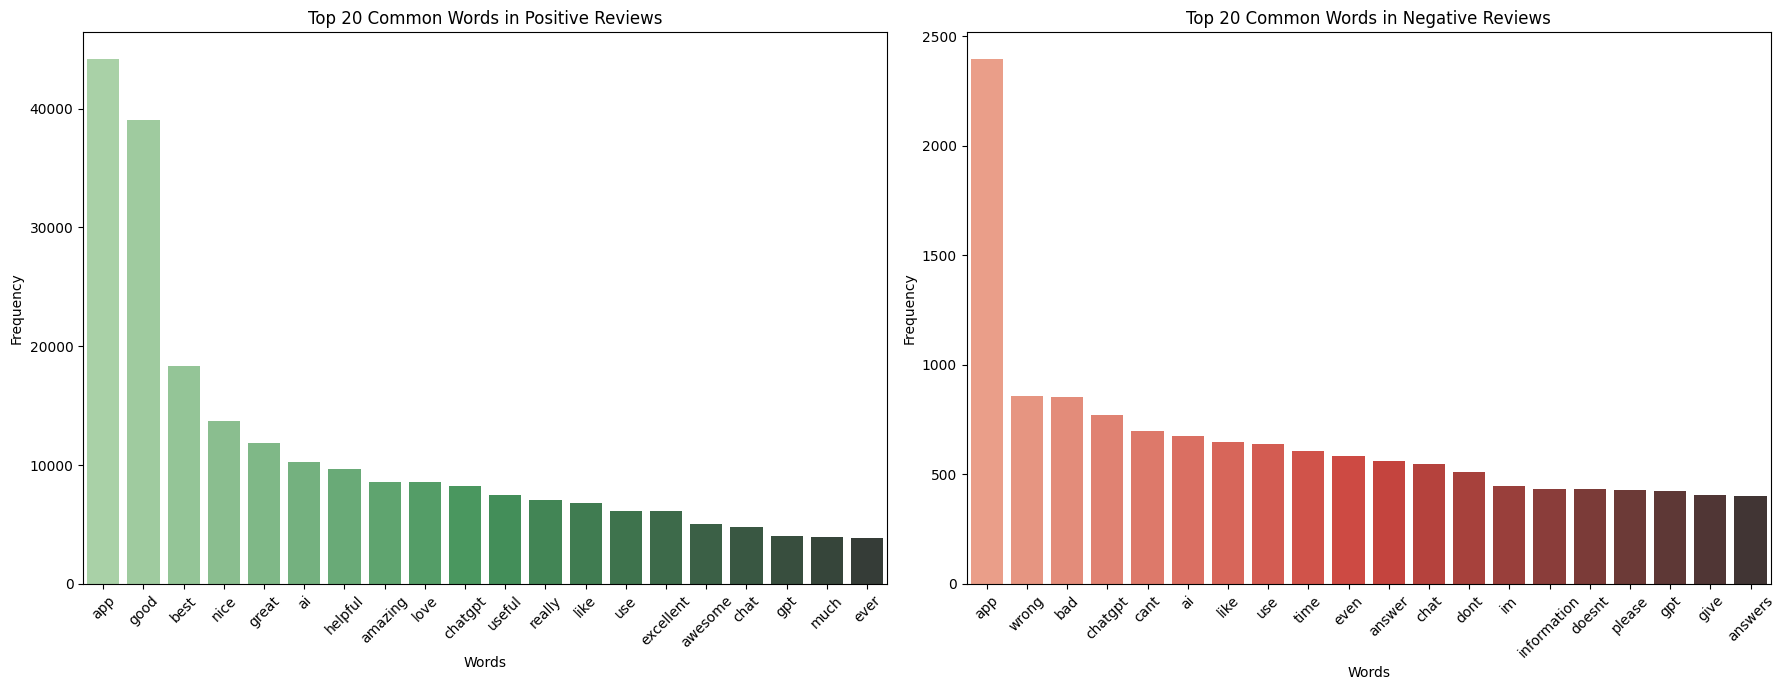

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot for Positive Words
sns.barplot(ax=axes[0], x=[word for word, count in common_positive_words], y=[count for word, count in common_positive_words], palette='Greens_d', hue=[word for word, count in common_positive_words], legend=False)
axes[0].set_title('Top 20 Common Words in Positive Reviews')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Negative Words
sns.barplot(ax=axes[1], x=[word for word, count in common_negative_words], y=[count for word, count in common_negative_words], palette='Reds_d', hue=[word for word, count in common_negative_words], legend=False)
axes[1].set_title('Top 20 Common Words in Negative Reviews')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

These two bar charts visualize the 20 most common words found in positive reviews (left) and negative reviews (right), along with their frequencies. This side-by-side comparison highlights the distinct vocabulary used by users expressing different sentiments, providing deeper insights into what drives positive and negative feedback.

Correlation between ratings and time

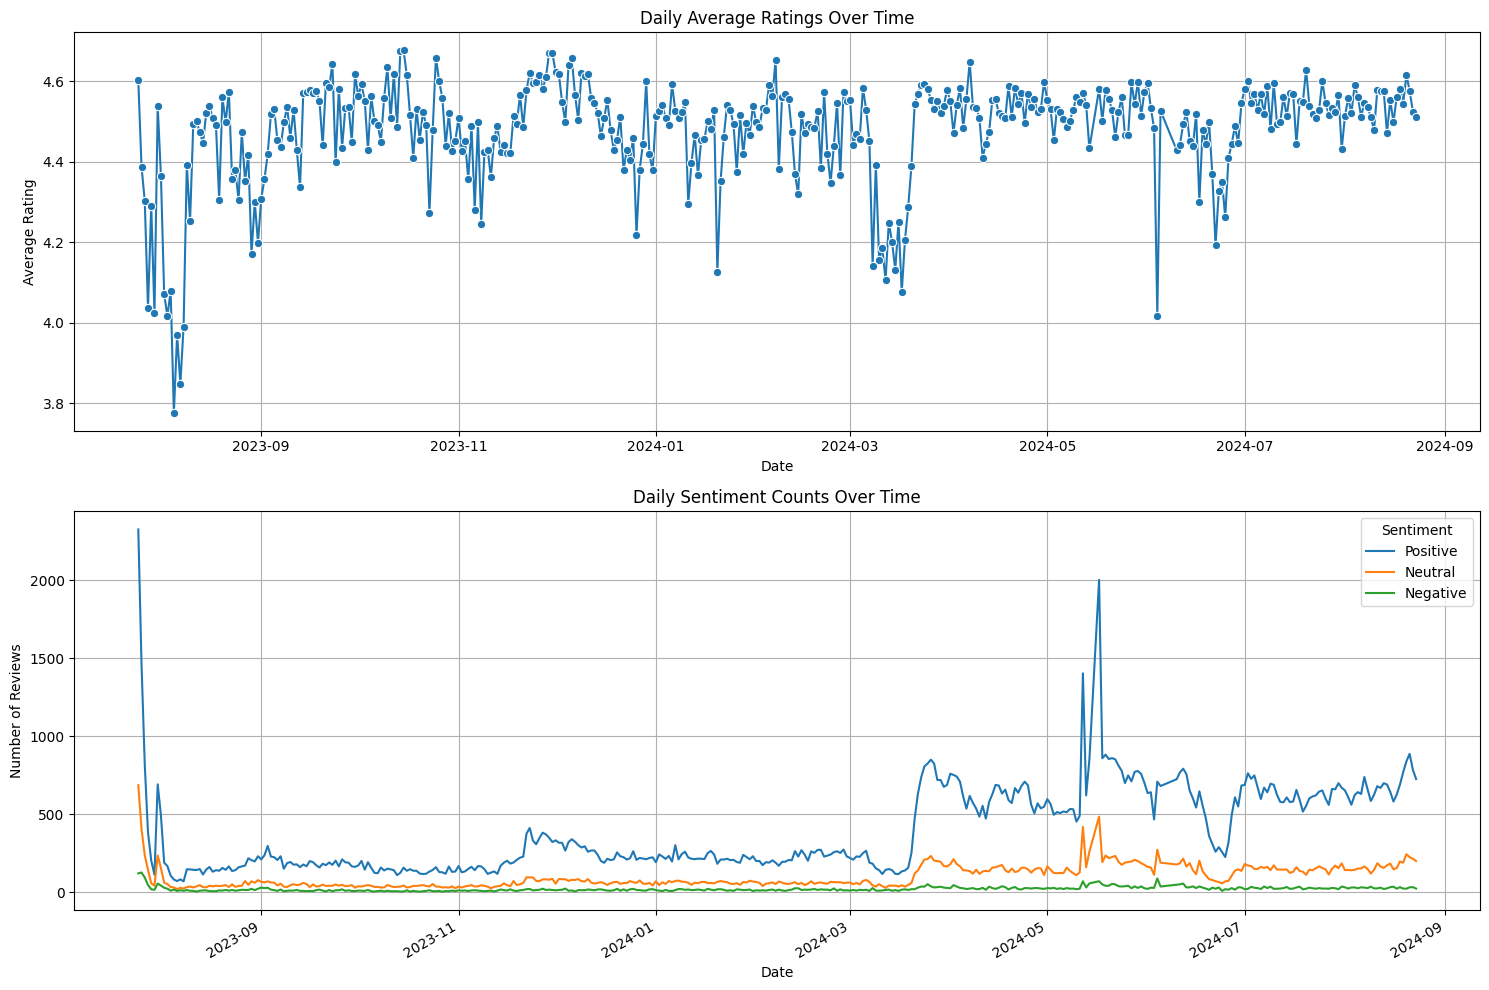

In [32]:
daily_average_ratings = df.groupby('review_day')['ratings'].mean().reset_index()
daily_average_ratings['review_day'] = pd.to_datetime(daily_average_ratings['review_day'])

daily_sentiment_counts = df.groupby(['review_day', 'sentiment']).size().unstack(fill_value=0)
daily_sentiment_counts = daily_sentiment_counts.reindex(columns=['Positive', 'Neutral', 'Negative'], fill_value=0)
daily_sentiment_counts.index = pd.to_datetime(daily_sentiment_counts.index)

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st subplot
sns.lineplot(x='review_day', y='ratings', data=daily_average_ratings, marker='o')
plt.title('Daily Average Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True)

plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd subplot
daily_sentiment_counts.plot(kind='line', ax=plt.gca(), legend=False)
plt.title('Daily Sentiment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()

This visualization presents two line charts. The top chart shows the daily average ratings, indicating trends in user satisfaction over time. The bottom chart, for comparison, displays the daily counts for Positive, Neutral, and Negative sentiments. This combined view allows for an analysis of whether changes in average ratings correspond with shifts in the distribution of sentiment categories.

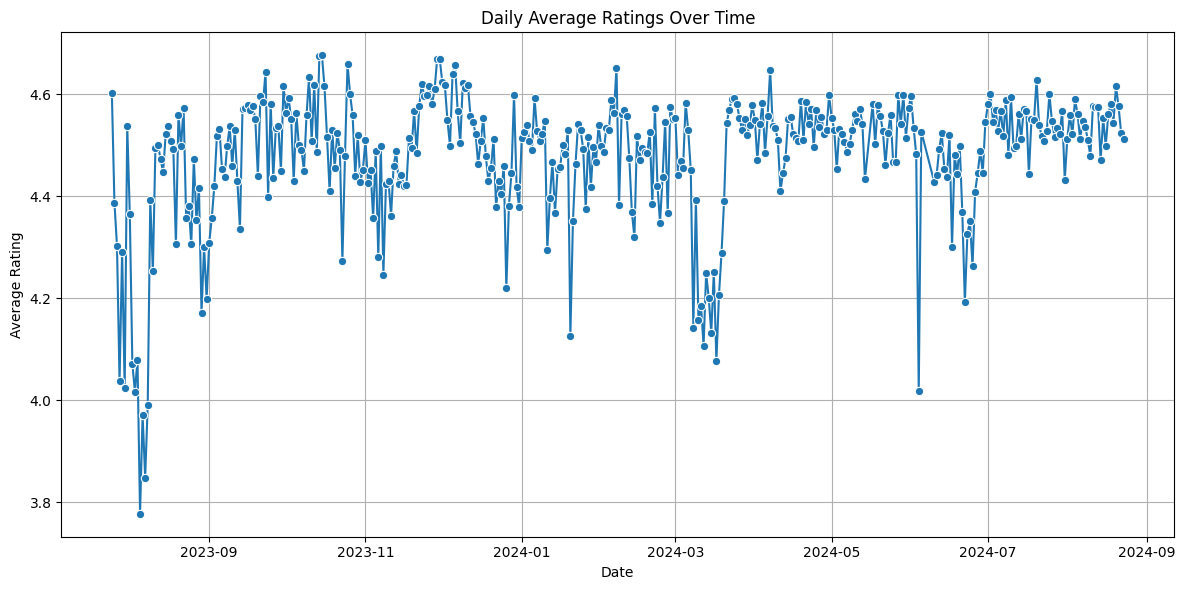

In [31]:
daily_average_ratings = df.groupby('review_day')['ratings'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='review_day', y='ratings', data=daily_average_ratings, marker='o')
plt.title('Daily Average Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

This line chart displays the daily average rating of reviews over time. It helps in identifying if there's any upward, downward, or stable trend in user ratings over the recorded period, potentially correlating with specific events or product updates.

In [30]:
polarity_stats = df.groupby('sentiment')['polarity'].describe()
print('Polarity Score Statistics per Sentiment:')
display(polarity_stats)

Polarity Score Statistics per Sentiment:


,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Negative,8155.0,-0.322242,0.263765,-1.000000e+00,-0.50,-0.25,-0.119246,-1.734723e-18
Neutral,38450.0,0.000000,0.000000,0.000000e+00,0.00,0.00,0.000000,0.000000e+00
Positive,150122.0,0.602900,0.272739,5.204170e-18,0.39,0.60,0.800000,1.000000e+00


This table provides descriptive statistics for the 'polarity' scores, grouped by their assigned 'sentiment' category (Positive, Neutral, Negative). It helps to understand the distribution, central tendency, and spread of polarity within each sentiment group, confirming how well the polarity values align with their sentiment classifications.

Daily Sentiment Counts

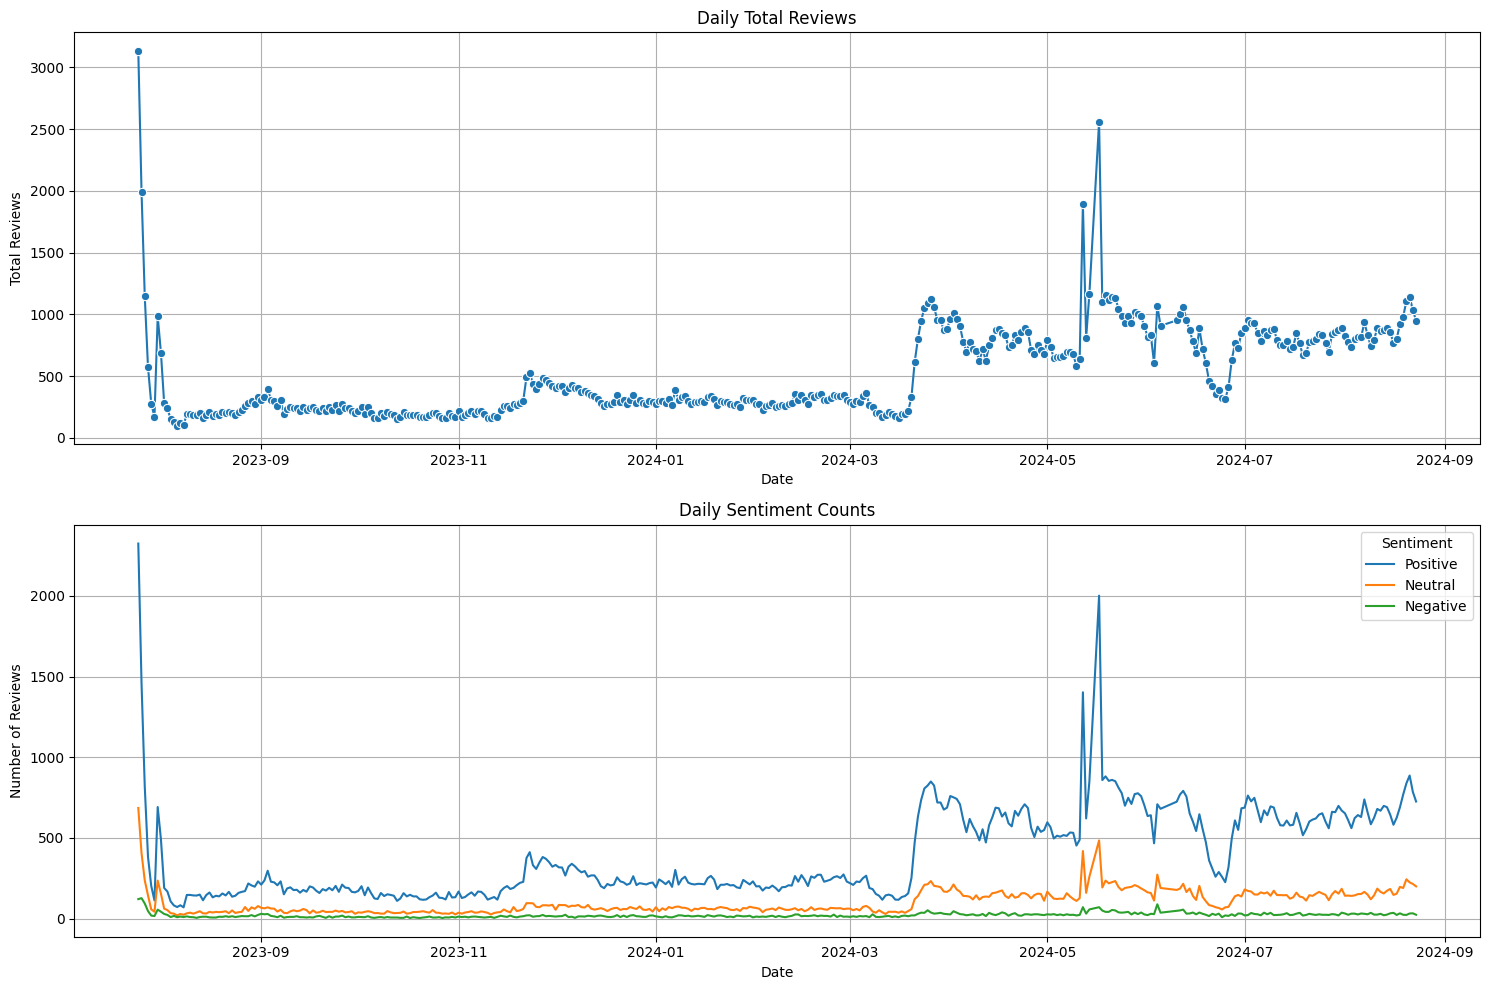

In [29]:
daily_sentiment_counts = df.groupby(['review_day', 'sentiment']).size().unstack(fill_value=0)
daily_sentiment_counts = daily_sentiment_counts.reindex(columns=['Positive', 'Neutral', 'Negative'], fill_value=0)

daily_total_reviews = df.groupby('review_day').size().reset_index(name='total_reviews')
daily_total_reviews['review_day'] = pd.to_datetime(daily_total_reviews['review_day'])

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st subplot
sns.lineplot(x='review_day', y='total_reviews', data=daily_total_reviews, marker='o')
plt.title('Daily Total Reviews')
plt.xlabel('Date')
plt.ylabel('Total Reviews')
plt.grid(True)

plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd subplot
daily_sentiment_counts.plot(kind='line', ax=plt.gca(), legend=False)
plt.title('Daily Sentiment Counts')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()

This visualization consists of two line charts. The top chart shows the total number of reviews received each day, allowing us to see review volume trends. The bottom chart, for comparison, displays the daily counts for Positive, Neutral, and Negative sentiments. This combined view helps in understanding if changes in overall review volume correlate with shifts in sentiment distribution over time.

In [28]:
display(df['sentiment'].value_counts())

,count
sentiment,
Positive,150122
Neutral,38450
Negative,8155


This code block identifies and lists the 20 most common words in both positive and negative reviews after removing common stop words and preprocessing the text. This can help in understanding the key themes and characteristics associated with each sentiment.

This line chart shows the daily distribution of Positive, Neutral, and Negative sentiments. It allows us to observe how the sentiment toward the product or service changes over the recorded period, potentially highlighting specific dates or events that influenced public opinion.

This bar chart displays the number of reviews classified into each sentiment category: Positive, Negative, and Neutral. It gives a quick overview of the overall sentiment of the dataset.

# Task
Analyze the polarity scores of user-provided words in the `df` DataFrame based on the `review` column and display a table of each word with its average polarity.

## Get Specific Words from User

### Subtask:
Ask the user to provide the specific words they want to analyze for polarity scores.


## Get Specific Words from User

### Subtask:
Ask the user to provide the specific words they want to analyze for polarity scores.

#### Instructions
Please provide the specific words you would like to analyze. Enter them as a comma-separated string.

**Reasoning**:
After instructing the user, the next step is to create a code cell that prompts the user to input the specific words as a comma-separated string, then processes this input into a list of words for further analysis.



In [34]:
specific_words_input = input("Please enter the specific words you want to analyze (comma-separated): ")
specific_words = [word.strip().lower() for word in specific_words_input.split(',') if word.strip()]

print(f"You entered the following words for analysis: {specific_words}")

Please enter the specific words you want to analyze (comma-separated): good
You entered the following words for analysis: ['good']


**Reasoning**:
Now that the specific words for analysis are obtained, the next step is to filter the DataFrame to include only reviews that contain these words, extract the polarity for each word, and then calculate the average polarity for each of the specific words provided by the user.



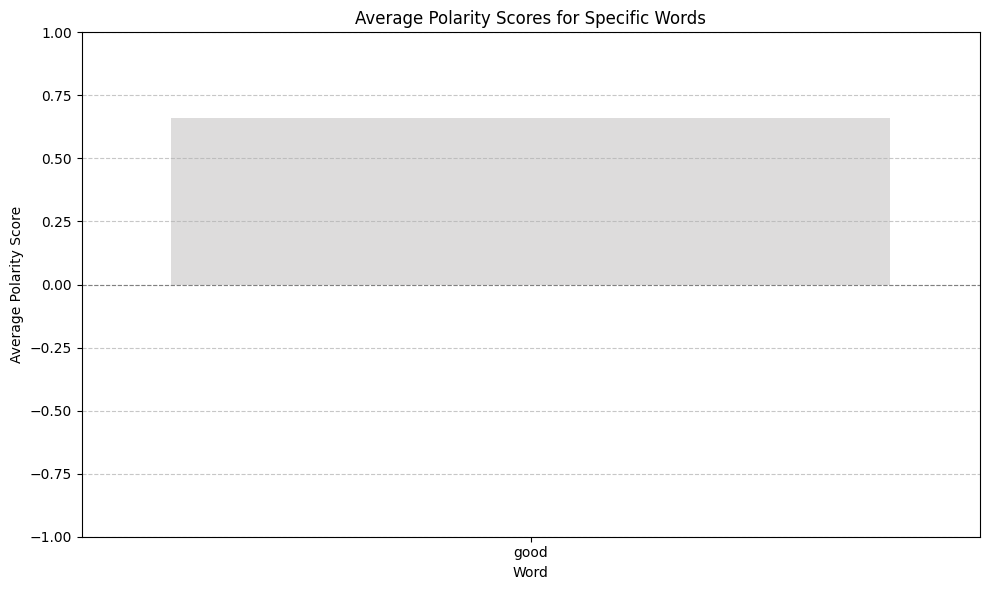

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Average Polarity', data=average_polarities_df, palette='coolwarm', hue='Word', legend=False)
plt.title('Average Polarity Scores for Specific Words')
plt.xlabel('Word')
plt.ylabel('Average Polarity Score')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a line at 0 for neutrality reference
plt.ylim(-1, 1) # Polarity typically ranges from -1 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This bar chart visualizes the average polarity score for each specific word you provided. The bars extend above zero for positive sentiment and below zero for negative sentiment, with a line at zero indicating neutrality. This provides a quick visual comparison of the sentiment associated with each word.

In [35]:
word_polarities = {word: [] for word in specific_words}

for index, row in df.iterrows():
    review_text = row['review'].lower()
    polarity = row['polarity']
    for word in specific_words:
        if word in review_text:
            word_polarities[word].append(polarity)

average_polarities = {word: sum(polarities) / len(polarities) if polarities else 0 for word, polarities in word_polarities.items()}

print("Average Polarity Scores for Specific Words:")
for word, avg_polarity in average_polarities.items():
    print(f"- {word}: {avg_polarity:.4f}")

Average Polarity Scores for Specific Words:
- good: 0.6609


**Reasoning**:
To present the average polarity scores in a structured table format, I will convert the `average_polarities` dictionary into a pandas DataFrame and then display it.



In [36]:
average_polarities_df = pd.DataFrame(list(average_polarities.items()), columns=['Word', 'Average Polarity'])
display(average_polarities_df)

,Word,Average Polarity
0,good,0.660906
